Praktikum zu Vorlesung
[__Modellreduktion parametrisierter Systeme__](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/)

Mario Ohlberger, Felix Schindler, Tim Keil

# Blatt 08, 03.07.2019

* Aktivieren Sie wie gewohnt ihre Arbeitsumgebung und starten Sie den Jupyter Notebook server, siehe zB [Blatt 1, Aufgabe 0](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/blatt_01__aufgaben.html#Aufgabe-0:-jupyter-Notebook-Server-starten).

* Importieren Sie `numpy` und `pymor.basic` und machen Sie `matplotlib` für das Notebook nutzbar.

In [1]:
%matplotlib notebook
import numpy as np
from pymor.basic import *
from matplotlib import pyplot as plt

Wir betrachten das Diffusionsproblem von [Blatt 04, Aufgabe 1](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/blatt_04__aufgaben.html#Aufgabe-1:-parametrische-Diffusion) mit dem Ausgabe Funktional

$$
s(v) := \frac{1}{|\Omega_\text{out}|} \int_{\Omega_\text{out}} v\; \text{d}x \quad\quad\text{mit } \Omega_\text{out} := (0, 1) \times (0.9, 1)
$$

und das folgende Minimierungsproblem: finde das Minimum

$$
\mu* := \underset{\mu \in \mathcal{P}}{\text{argmin}} J(\mu)
$$

wobei $J(\mu) := s(u_\mu)$, und $u_\mu$ für $\mu \in \mathcal{P}$ die Lösung des Diffusionsproblems sei; $J$ wird oft _Paramter-zu-Ausgabe_ Abbilding oder _input-output map_ genannt.

## Aufgabe 1: der schwache greedy Algorithmus

1. Erstellen Sie ein analytisches Problem unter Verwedung von `problem_B4_A1_parametric` und fügen Sie dem Problem das Ausgabefunktional mit der id `output` hinzu (siehe auch [API Dokumentation von `StationaryProblem`](http://docs.pymor.org/en/0.5.1/generated/pymor.analyticalproblems.html#pymor.analyticalproblems.elliptic.StationaryProblem)).

In [2]:
from problems import problem_B4_A1_parametric

problem = problem_B4_A1_parametric()
problem = problem.with_(functionals={'output': ('l2', ExpressionFunction('(x[..., 1] >= 0.9) * 10.', 2, ())) })

00:00 |WARNING|BitmapFunction: Image R.png not in grayscale mode. Convertig to grayscale.
00:00 |WARNING|BitmapFunction: Image B.png not in grayscale mode. Convertig to grayscale.


2. Diskretisieren Sie das Problem mit Hilfe des `cg` discretizers und werten Sie $J$ für den Paramter $\mu = $`{'R': 1, 'B': 1}` aus.

  * extrahieren Sie dazu das Ausgabefunktional `s` aus dem `operators`-dict der Diskretisierung
  * definieren Sie $J$

In [3]:
d, _ = discretize_stationary_cg(problem)
print(d.operators.keys())

00:00 DiffusionOperatorP1: Calulate gradients of shape functions transformed by reference map ...
00:00 DiffusionOperatorP1: Calculate all local scalar products beween gradients ...
00:00 DiffusionOperatorP1: Determine global dofs ...
00:00 DiffusionOperatorP1: Boundary treatment ...
00:00 DiffusionOperatorP1: Assemble system matrix ...
00:00 DiffusionOperatorP1: Calulate gradients of shape functions transformed by reference map ...
00:00 DiffusionOperatorP1: Calculate all local scalar products beween gradients ...
00:00 DiffusionOperatorP1: Determine global dofs ...
00:00 DiffusionOperatorP1: Boundary treatment ...
00:00 DiffusionOperatorP1: Assemble system matrix ...
00:00 DiffusionOperatorP1: Calulate gradients of shape functions transformed by reference map ...
00:00 DiffusionOperatorP1: Calculate all local scalar products beween gradients ...
00:00 DiffusionOperatorP1: Determine global dofs ...
00:00 DiffusionOperatorP1: Boundary treatment ...
00:00 DiffusionOperatorP1: Assemble s

dict_keys(['output_functional', 'operator', 'rhs'])


In [4]:
s = d.operators['output_functional']

def J(mu):
    U = d.solve(mu)
    return s.apply(U).data[0][0]

print(J([1, 1]))

00:01 StationaryDiscretization: Solving Blatt4_Aufgabe_1_parametric_CG for {B: 1, R: 1} ...


0.003584674108277644


3. Erstellen Sie einen `CoerciveRBReductor` mit entsprechenden `product` und `coercivity_estimator`

In [5]:
reductor = CoerciveRBReductor(
        d, product=d.h1_0_semi_product,
        coercivity_estimator=ExpressionParameterFunctional('min([1, R, B])', d.parameter_type))

4. Erstellen Sie eine reduzierte Basis mit Hilfe eines (weak discrete) greedy Algorithmus.

  * Machen Sie sich mit dem [`greedy` Algorithmus in pyMOR](http://docs.pymor.org/en/0.5.1/generated/pymor.algorithms.html#pymor.algorithms.greedy.greedy) vertraut.
  Dieser Nutzt den Residuenbasierten offline/online zerlegbaren Fehlerschätzer (_weak_) des `CoerciveRBReductor`, um den Modellreduktionsfehler online-effizient für eine große Menge an Trainingsparametern (_discrete_) zu schätzen.
  Es werden also für jedes Element der reduzierten Basis nur eine hochdimensionale Lösung der PDE benötigt.
  
  * Verwenden Sie eine Trainingsmenge von 10000 gleichverteilten Paramtern.
  
  * Stellen Sie sicher, dass der maximale geschätzte Modellreduktionsfehler (über die Trainingsmenge) `1e-3` nicht überschreitet.
  
  * Stellen Sie sicher, dass die reduzierte Basis mit Hilfe eines Gram-Schmidt Verfahrens orthonormalisiert wird, setzen Sie hierzu `extension_params={'method': 'gram_schmidt'}`.

In [6]:
greedy_data = greedy(
    d, reductor, d.parameter_space.sample_uniformly(100),
    atol=1e-3,
    extension_params={'method': 'gram_schmidt'}
)

00:01 greedy: Started greedy search on 10000 samples
00:01 greedy: Reducing ...
00:01 |   CoerciveRBReductor: RB projection ...
00:01 |   CoerciveRBReductor: Assembling error estimator ...
00:01 |   |   ResidualReductor: Estimating residual range ...
00:01 |   |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
00:02 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:02 |   |   ResidualReductor: Projecting residual operator ...
00:02 greedy: Estimating errors ...
00:04 greedy: Maximum error after 0 extensions: 5199.189979573521 (mu = {B: 0.0001, R: 0.0001})
00:04 greedy: Computing solution snapshot for mu = {B: 0.0001, R: 0.0001} ...
00:04 |   StationaryDiscretization: Solving Blatt4_Aufgabe_1_parametric_CG for {B: 0.0001, R: 0.0001} ...
00:04 greedy: Extending basis with solution snapshot ...
      
00:04 greedy: Reducing ...
00:04 |   CoerciveRBReductor: RB projection ...
00:05 |   CoerciveRBReductor: Assembling error estimator ...
00:05 |   | 

00:29 |   |   ResidualReductor: Estimating residual range ...
00:29 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 7 ...
00:29 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:29 |   |   |   |   gram_schmidt: Removing vector 21 of norm 1.0456690646094309e-15
00:29 |   |   |   |   gram_schmidt: Orthonormalizing vector 23 again
00:29 |   |   |   |   gram_schmidt: Orthonormalizing vector 24 again
00:29 |   |   ResidualReductor: Projecting residual operator ...
00:29 greedy: Estimating errors ...
00:33 greedy: Maximum error after 8 extensions: 15.670922798571622 (mu = {B: 0.6364, R: 0.0001})
00:33 greedy: Computing solution snapshot for mu = {B: 0.6364, R: 0.0001} ...
00:33 |   StationaryDiscretization: Solving Blatt4_Aufgabe_1_parametric_CG for {B: 0.6364, R: 0.0001} ...
00:33 greedy: Extending basis with solution snapshot ...
00:33 |   gram_schmidt: Orthonormalizing vector 8 again
      
00:33 greedy: Reducing ...
00:33 |   CoerciveRBReductor: 

00:55 |   |   ResidualReductor: Projecting residual operator ...
00:55 greedy: Estimating errors ...
00:59 greedy: Maximum error after 15 extensions: 0.2316359088110416 (mu = {B: 0.010199999999999999, R: 1.0})
00:59 greedy: Computing solution snapshot for mu = {B: 0.010199999999999999, R: 1.0} ...
00:59 |   StationaryDiscretization: Solving Blatt4_Aufgabe_1_parametric_CG for {B: 0.010199999999999999, R: 1.0} ...
00:59 greedy: Extending basis with solution snapshot ...
00:59 |   gram_schmidt: Orthonormalizing vector 15 again
      
00:59 greedy: Reducing ...
00:59 |   CoerciveRBReductor: RB projection ...
00:59 |   CoerciveRBReductor: Assembling error estimator ...
00:59 |   |   ResidualReductor: Estimating residual range ...
00:59 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 15 ...
00:59 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:59 |   |   |   |   gram_schmidt: Removing vector 45 of norm 1.7420316366544852e-15
00:59 |   |   |   |   g

01:36 |   |   ResidualReductor: Estimating residual range ...
01:36 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 22 ...
01:36 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
01:36 |   |   |   |   gram_schmidt: Removing vector 71 of norm 5.832003254848112e-14
01:36 |   |   |   |   gram_schmidt: Orthonormalizing vector 73 again
01:36 |   |   |   |   gram_schmidt: Orthonormalizing vector 74 again
01:36 |   |   ResidualReductor: Projecting residual operator ...
01:36 greedy: Estimating errors ...
01:42 greedy: Maximum error after 23 extensions: 0.014536586870023361 (mu = {B: 0.1011, R: 1.0})
01:42 greedy: Computing solution snapshot for mu = {B: 0.1011, R: 1.0} ...
01:42 |   StationaryDiscretization: Solving Blatt4_Aufgabe_1_parametric_CG for {B: 0.1011, R: 1.0} ...
01:42 greedy: Extending basis with solution snapshot ...
01:42 |   gram_schmidt: Orthonormalizing vector 23 again
      
01:42 greedy: Reducing ...
01:42 |   CoerciveRBReductor: RB pr

02:27 |   StationaryDiscretization: Solving Blatt4_Aufgabe_1_parametric_CG for {B: 0.0304, R: 1.0} ...
02:28 greedy: Extending basis with solution snapshot ...
02:28 |   gram_schmidt: Orthonormalizing vector 30 again
      
02:28 greedy: Reducing ...
02:28 |   CoerciveRBReductor: RB projection ...
02:28 |   CoerciveRBReductor: Assembling error estimator ...
02:28 |   |   ResidualReductor: Estimating residual range ...
02:28 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 30 ...
02:28 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
02:28 |   |   |   |   gram_schmidt: Orthonormalizing vector 101 again
02:28 |   |   |   |   gram_schmidt: Orthonormalizing vector 103 again
02:28 |   |   |   |   gram_schmidt: Orthonormalizing vector 104 again
02:28 |   |   ResidualReductor: Projecting residual operator ...
02:28 greedy: Estimating errors ...
02:35 greedy: Maximum error after 31 extensions: 0.0013002145648843286 (mu = {B: 0.0304, R: 0.0001})
02:35 gree

5. Stellen Sie den Fehlerabfall während der Basisgenerierung mit Hilfe der vom greedy Algorithmus zurück gegebenen Daten grafisch dar.

<IPython.core.display.Javascript object>


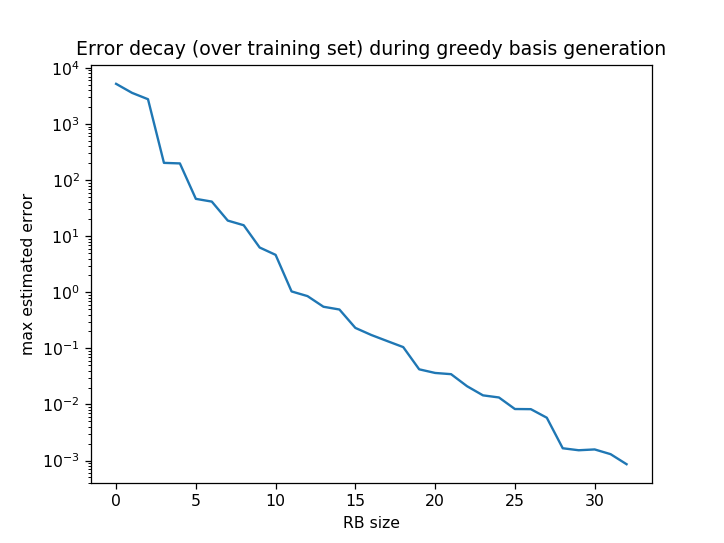

Text(0.5, 1.0, 'Error decay (over training set) during greedy basis generation')

In [7]:
max_errs = greedy_data['max_errs']
plt.figure()
plt.semilogy(max_errs)
plt.xlabel('RB size')
plt.ylabel('max estimated error')
plt.title('Error decay (over training set) during greedy basis generation')

## Aufgabe 2: PDE-constrained minimization

1. Definieren Sie eine Funktione

   ```
   def parameter_to_output(R, B):
       ...
   ```
   
   welche mit Hilfe der reduzierten Diskretisierung und des reduzierten Ausgabefunktionals eine RB-Approximation von $J$ berechnet.
   
   * Extrahieren Sie dazu die reduzierte Diskretisierung aus den vom greedy Algorithmus übergebenen Daten.

In [8]:
rd = greedy_data['rd']
J = rd.operators['output_functional']

def parameter_to_output(R, B):
    u = rd.solve({'R': R, 'B': B})
    return J.apply(u).data[0][0]

In [9]:
def plot_3d(x, y, f, xlabel='X', ylabel='Y'):
    # compute_value_matrix
    f_of_x = np.zeros((len(x), len(y)))
    import time
    t = time.time()
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[jj][ii] = f(x[ii], y[jj]) # ii and jj are switched on purpose!
    x, y = np.meshgrid(x, y)
    print('{} evaluations took {}s'.format(len(x)*len(y), time.time() - t))
    # plot
    from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
    from matplotlib import cm # required for colormaps
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, f_of_x, cmap=cm.viridis)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.invert_xaxis()
    return ax

def plot_point(ax, point, color):
    x, y = point[0], point[1]
    ax.plot([x, x], [y, y], ax.get_zlim(), color, zorder=10)

2. Erstellen Sie einen 3d Plot der RB-Approximation von $J$ mit Hilfe von `plot_3d`.

   * Geben Sie als `x`-Werte 100 gleichverteilte Werte im Definitionsbereich der Parameterkomponente `R` an, entsprechend als `y`-Werte `B`. Nutzen Sie dazu den Parameterraum der reduzierten Diskretisierung.

10000 evaluations took 3.9125216007232666s


<IPython.core.display.Javascript object>


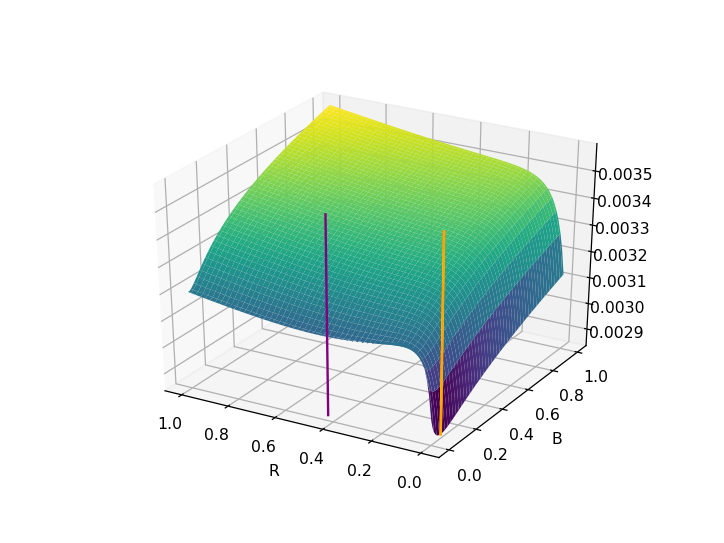

In [10]:
ax = plot_3d(np.linspace(*rd.parameter_space.ranges['R'], 100),
             np.linspace(*rd.parameter_space.ranges['B'], 100),
             parameter_to_output, xlabel='R', ylabel='B')
xlocs, xlabels = plt.xticks()
ylocs, ylabels = plt.yticks()

3. Machen Sie sich mit der [`minimize` Funktion in `scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) vertraut und vervollständigen Sie die Definition von `find_minimum`, um das Minimierungsproblem zu lösen.

   * wählen Sie als Minimierer den `BFGS` Algorithmus für "Bound-Constrained minimization"
   
   * lassen Sie den Gradienten von $J$ mit Hilfe von Finiten Differenzen Approximieren
   
   * nutzen Sie den Paramterraum der reduzierten Diskretisierung um das "Bound-Constrained" zu definieren
   
   * übergeben Sie `options={'ftol': 1e-15}`

In [11]:
def find_minimum(initial_guess):
    from scipy.optimize import minimize
    return minimize(lambda mu: parameter_to_output(mu[0], mu[1]),
                    initial_guess,
                    method='L-BFGS-B', jac=False,
                    bounds=(rd.parameter_space.ranges['R'], rd.parameter_space.ranges['B']),
                    options={'ftol': 1e-15})

def print_report(result):
    if result.success:
        print('succeded after {} iterations (required {} PDE solves)'.format(result.nit, result.nfev))
        print('J({}) = {}'.format(result.x, result.fun))
    else:
        print('failed!')

4. Lassen Sie die Minimierung für vier verschiedene Anfangswerte mit Hilfe des folgenden Codes druchlaufen. Was können Sie beobachten?

In [12]:
for mu, color in zip(rd.parameter_space.sample_uniformly(2), ('red', 'yellow', 'orange', 'purple')):
    initial_guess = [mu['R'], mu['B']]    
    print('minimizing from {}...'.format(initial_guess))
    result = find_minimum(initial_guess)
    print_report(result)
    plot_point(ax, result.x, color)
    print('')

minimizing from [array(0.0001), array(0.0001)]...
succeded after 7 iterations (required 24 PDE solves)
J([0.0001     0.07097346]) = 0.002849831289926982

minimizing from [array(1.), array(0.0001)]...
succeded after 9 iterations (required 39 PDE solves)
J([0.0001     0.07093573]) = 0.0028498314120881576

minimizing from [array(0.0001), array(1.)]...
succeded after 3 iterations (required 51 PDE solves)
J([0.0001     0.07163161]) = 0.0028498319014712424

minimizing from [array(1.), array(1.)]...
succeded after 10 iterations (required 69 PDE solves)
J([0.4280417  0.01167548]) = 0.0031462490223433167



5. Erstellen Sie einen 3d plot der RB-Approximation von $J$ wie oben, wobei die $x$ und $y$ Punkte nicht gleichverteilt, sonder mit Hilfe des Logarithmus zur Basis 10 verteilt sind.

10000 evaluations took 3.5173699855804443s


<IPython.core.display.Javascript object>


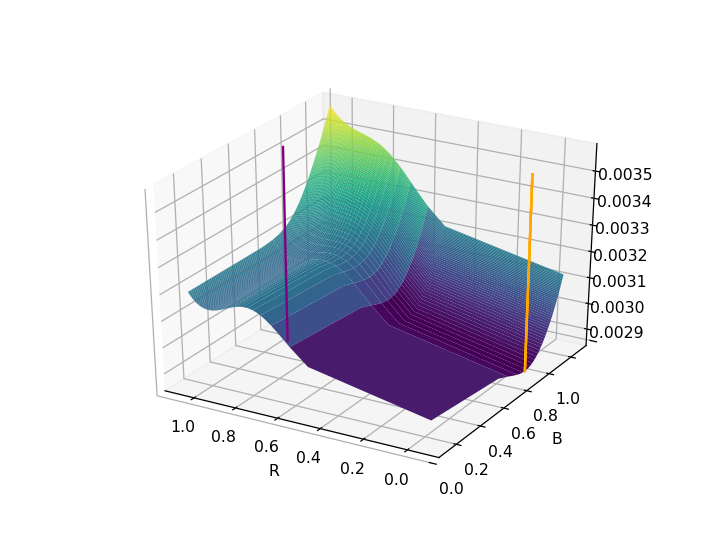

([<matplotlib.axis.XTick at 0x7f68492632b0>,
 <a list of 8 Text yticklabel objects>)

In [15]:
ax = plot_3d(np.log10(np.linspace(*rd.parameter_space.ranges['R'], 100)),
             np.log10(np.linspace(*rd.parameter_space.ranges['B'], 100)),
             lambda x, y: parameter_to_output(10**x, 10**y), xlabel='R', ylabel='B')
xlocs, _ = plt.xticks()
ylocs, _ = plt.yticks()
plt.xticks(np.linspace(min(xlocs), max(xlocs), len(xlabels)), xlabels)
plt.yticks(np.linspace(min(ylocs), max(ylocs), len(ylabels)), ylabels)

6. Wiederholen Sie auch die Minimierung und grafische Darstellung der gefundenen Minima. Passen Sie letzteren entsprechend an.

In [16]:
for mu, color in zip(rd.parameter_space.sample_uniformly(2), ('red', 'yellow', 'orange', 'purple')):
    initial_guess = [mu['R'], mu['B']]    
    print('minimizing from {}...'.format(initial_guess))
    result = find_minimum(initial_guess)
    print_report(result)
    plot_point(ax, np.log10(result.x), color)
    print('')

minimizing from [array(0.0001), array(0.0001)]...
succeded after 7 iterations (required 24 PDE solves)
J([0.0001     0.07097346]) = 0.002849831289926982

minimizing from [array(1.), array(0.0001)]...
succeded after 9 iterations (required 39 PDE solves)
J([0.0001     0.07093573]) = 0.0028498314120881576

minimizing from [array(0.0001), array(1.)]...
succeded after 3 iterations (required 51 PDE solves)
J([0.0001     0.07163161]) = 0.0028498319014712424

minimizing from [array(1.), array(1.)]...
succeded after 10 iterations (required 69 PDE solves)
J([0.4280417  0.01167548]) = 0.0031462490223433167

